# Entrenamiento y Evaluación de Modelos

Entrenamiento de múltiples algoritmos de machine learning para predecir el no-show médico

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import joblib
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

## Configuración de Modelos

In [4]:
# Configuración centralizada de modelos
MODELOS_CONFIG = {
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'Decision Tree': DecisionTreeClassifier(random_state=42)
}

# Métricas de evaluación
METRICAS = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

# Configuración de validación cruzada
CV_CONFIG = {'n_splits': 5, 'shuffle': True, 'random_state': 42}


PARAM_GRIDS = {
    'Random Forest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
}



## Carga de Datos Preprocesados

In [5]:
# Cargar datos preprocesados
ruta_datos = Path.cwd() / "data"
ruta_modelos = Path.cwd() / "models"

X_train = pd.read_csv(ruta_datos / "X_train.csv")
X_test = pd.read_csv(ruta_datos / "X_test.csv") 
y_train = pd.read_csv(ruta_datos / "y_train.csv").squeeze()
y_test = pd.read_csv(ruta_datos / "y_test.csv").squeeze()

print(f"Datos de entrenamiento: {X_train.shape}")
print(f"Datos de prueba: {X_test.shape}")
print(f"Distribución de clases en entrenamiento:")
print(y_train.value_counts(normalize=True).round(3))

Datos de entrenamiento: (57567, 16)
Datos de prueba: (14392, 16)
Distribución de clases en entrenamiento:
No_show_numeric
0    0.715
1    0.285
Name: proportion, dtype: float64


In [6]:
# Cargar objetos de transformación
with open(ruta_modelos / "scaler.pkl", 'rb') as f:
    scaler = pickle.load(f)
with open(ruta_modelos / "label_encoder_gender.pkl", 'rb') as f:
    le_gender = pickle.load(f)
with open(ruta_modelos / "mappings.pkl", 'rb') as f:
    mappings = pickle.load(f)

print(f"Variables finales: {len(mappings['variables_finales'])}")

Variables finales: 16


## Evaluación Inicial con Validación Cruzada

In [7]:

cv = StratifiedKFold(**CV_CONFIG)
resultados_cv = {}

print("=" * 60)

for nombre, modelo in MODELOS_CONFIG.items():
    print(f"\nModelo: {nombre}")
    resultados_cv[nombre] = {}
    
    for metrica in METRICAS:
        try:
            scores = cross_val_score(modelo, X_train, y_train, cv=cv, scoring=metrica)
            
            resultados_cv[nombre][metrica] = {
                'mean': scores.mean(),
                'std': scores.std(),
                'scores': scores
            }
            print(f"  {metrica}: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")
            
        except Exception as e:
            print(f"  {metrica}: Error - {str(e)}")
            resultados_cv[nombre][metrica] = {
                'mean': 0.0,
                'std': 0.0,
                'scores': np.array([0.0] * CV_CONFIG['n_splits'])
            }


Modelo: Random Forest
  accuracy: 0.6533 (+/- 0.0036)
  precision: 0.3422 (+/- 0.0107)
  recall: 0.2340 (+/- 0.0128)
  f1: 0.2779 (+/- 0.0122)
  roc_auc: 0.5515 (+/- 0.0081)

Modelo: Decision Tree
  accuracy: 0.6371 (+/- 0.0085)
  precision: 0.3291 (+/- 0.0171)
  recall: 0.2625 (+/- 0.0133)
  f1: 0.2920 (+/- 0.0145)
  roc_auc: 0.5244 (+/- 0.0068)


In [8]:
# DataFrame con resultados de validación cruzada
df_resultados = []

for modelo, metricas_dict in resultados_cv.items():
    fila = {'Modelo': modelo}
    for metrica, valores in metricas_dict.items():
        fila[f'{metrica}_mean'] = valores['mean']
        fila[f'{metrica}_std'] = valores['std']
    df_resultados.append(fila)

df_resultados = pd.DataFrame(df_resultados)
df_resultados_sorted = df_resultados.sort_values('roc_auc_mean', ascending=False)

print("\nResultados de Validación Cruzada ordenados por ROC-AUC:")
print("=" * 80)
columnas = ['Modelo', 'accuracy_mean', 'precision_mean', 'recall_mean', 'f1_mean', 'roc_auc_mean']
print(df_resultados_sorted[columnas].round(4))


Resultados de Validación Cruzada ordenados por ROC-AUC:
          Modelo  accuracy_mean  precision_mean  recall_mean  f1_mean  \
0  Random Forest         0.6533          0.3422       0.2340   0.2779   
1  Decision Tree         0.6371          0.3291       0.2625   0.2920   

   roc_auc_mean  
0        0.5515  
1        0.5244  


## Visualización de Resultados

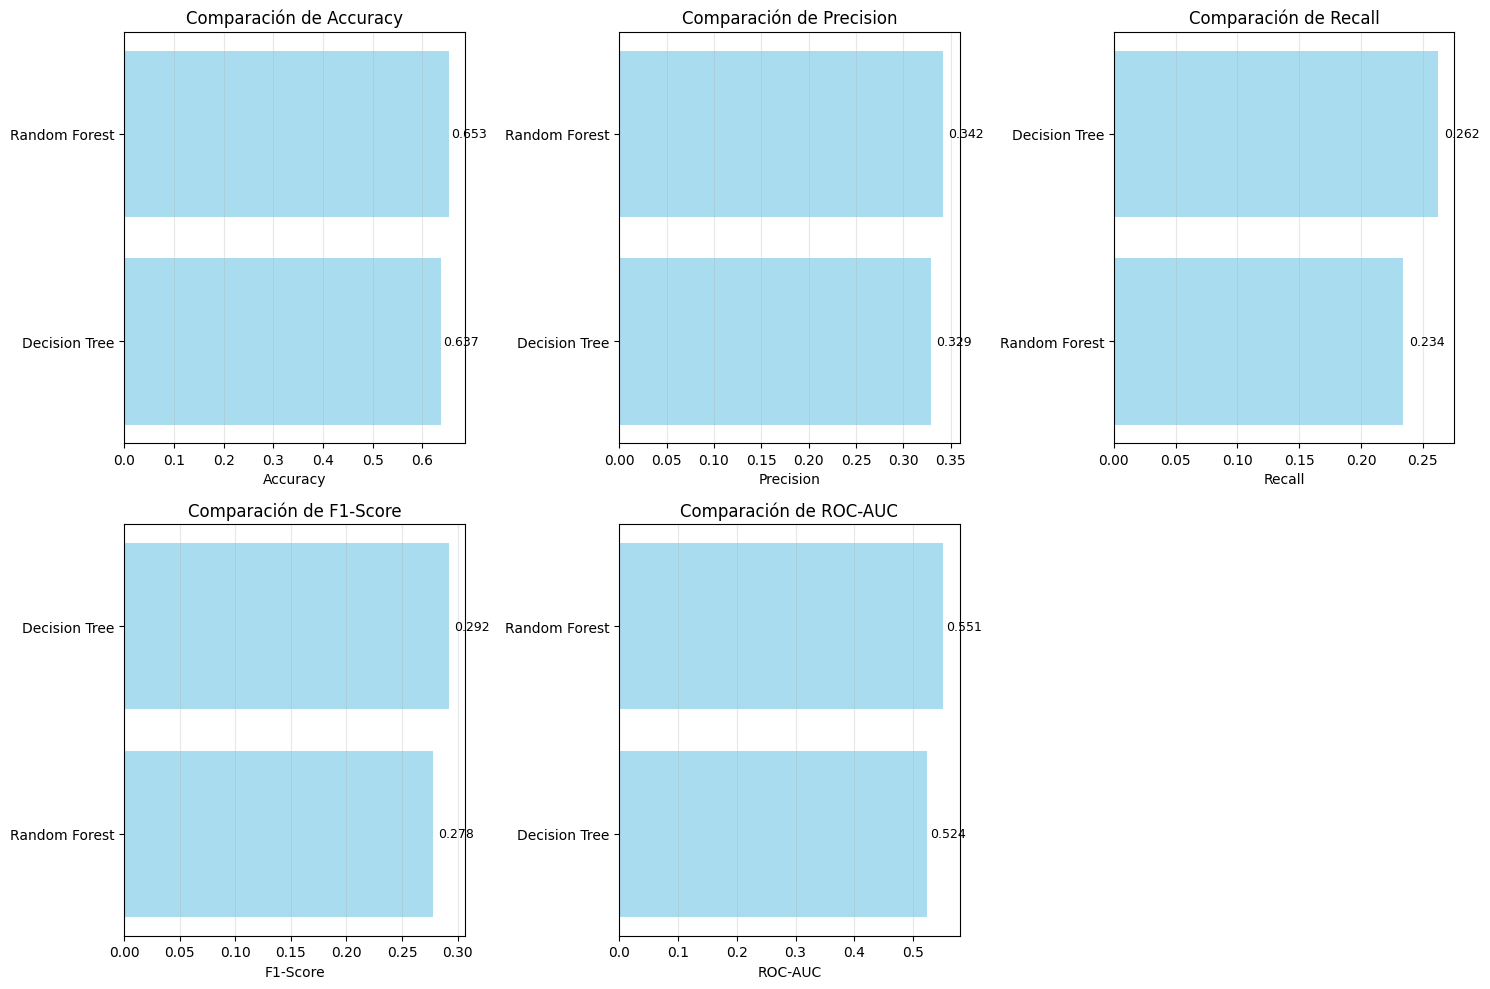

In [9]:

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

metricas_plot = ['accuracy_mean', 'precision_mean', 'recall_mean', 'f1_mean', 'roc_auc_mean']
titulos = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']

for i, (metrica, titulo) in enumerate(zip(metricas_plot, titulos)):
    df_plot = df_resultados_sorted.sort_values(metrica, ascending=True)
    
    bars = axes[i].barh(df_plot['Modelo'], df_plot[metrica], 
                       color='skyblue', alpha=0.7)
    axes[i].set_xlabel(titulo)
    axes[i].set_title(f'Comparación de {titulo}')
    axes[i].grid(axis='x', alpha=0.3)
    
    # Añadir valores en las barras
    for bar, valor in zip(bars, df_plot[metrica]):
        axes[i].text(valor + 0.005, bar.get_y() + bar.get_height()/2, 
                    f'{valor:.3f}', va='center', fontsize=9)

# Remover subplot vacío
axes[5].remove()

plt.tight_layout()
plt.show()

## Optimización de Modelos

In [10]:
# Selección del mejor modelo
mejor_modelo_nombre = df_resultados_sorted.iloc[0]['Modelo']
mejor_modelo = MODELOS_CONFIG[mejor_modelo_nombre]

print(f"\nMejor modelo: {mejor_modelo_nombre}")
print(f"ROC-AUC: {df_resultados_sorted.iloc[0]['roc_auc_mean']:.4f}")

# Entrenar el modelo final
mejor_modelo.fit(X_train, y_train)

y_pred = mejor_modelo.predict(X_test)
y_pred_proba = mejor_modelo.predict_proba(X_test)[:, 1]

# Métricas 
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)


print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"ROC-AUC:   {roc_auc:.4f}")


Mejor modelo: Random Forest
ROC-AUC: 0.5515
Accuracy:  0.6578
Precision: 0.3518
Recall:    0.2373
F1-Score:  0.2834
ROC-AUC:   0.5519


In [11]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
nombre_archivo = f"medical_noshow_{mejor_modelo_nombre.lower().replace(' ', '_')}_{timestamp}"

# Guardar modelo
modelo_path = ruta_modelos / f"{nombre_archivo}.joblib"
joblib.dump(mejor_modelo, modelo_path)


['c:\\Users\\paula\\Documents\\udemedellin\\proyecto\\medical-noshow-prediction\\models\\medical_noshow_random_forest_20251102_152954.joblib']